In this notebook, we will be building and training LSTM and GRU to predict the stock market. You do not allow to use TensorFlow and Keras libraries.

## 1. Libraries and settings

In [162]:
# Import libraries 
# Notice that it is important that which libraries you use, so you should import
# libraries just here in your code
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import math
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from math import sqrt
import torch
import torch.nn as nn


## 2. Load data

In [163]:
# Read data 
df = pd.read_csv('time_series.csv')
df = df.drop('<TICKER>', axis=1)
df = df.drop('<PER>', axis=1)
df_ibm=df[['<CLOSE>']]
df_ibm.info()
df_ibm

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2767 entries, 0 to 2766
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   <CLOSE>  2767 non-null   float64
dtypes: float64(1)
memory usage: 21.7 KB


,<CLOSE>
0,11.23
1,11.32
2,10.78
3,10.70
4,10.86
...,...
2762,216.57
2763,207.02
2764,205.22
2765,207.12


In [164]:
df_ibm=df_ibm.fillna(method='ffill')

scaler = MinMaxScaler(feature_range=(-1, 1))
df_ibm['<CLOSE>'] = scaler.fit_transform(df_ibm['<CLOSE>'].values.reshape(-1,1))

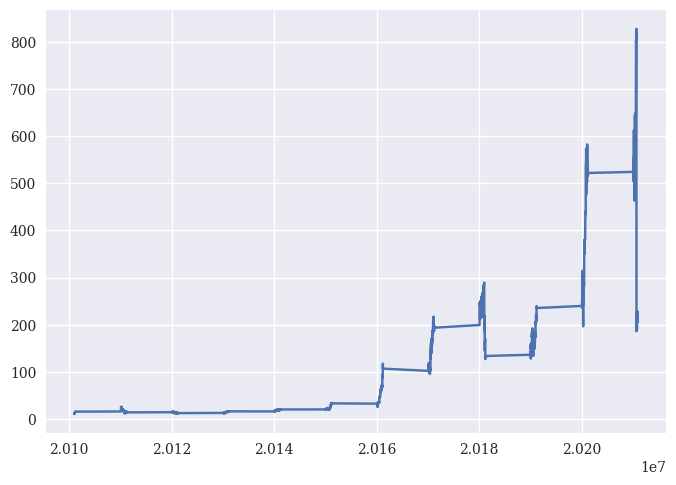

In [165]:
# Plot close prices ("<CLOSE>") based on dates ("<DATE>") 

#####################
plt.plot(df["<DATE>"], df["<CLOSE>"])
plt.show()
#####################

In [166]:
# function to create train, test data given stock data and sequence length
def load_data(stock, look_back):
    data_raw = stock.values # convert to numpy array
    data = []
    
    # create all possible sequences of length look_back
    for index in range(len(data_raw) - look_back): 
        data.append(data_raw[index: index + look_back])
    
    data = np.array(data);
    test_set_size = int(np.round(0.2*data.shape[0]));
    train_set_size = data.shape[0] - (test_set_size);
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]
    
    return [x_train, y_train, x_test, y_test]

look_back = 60 # choose sequence length
x_train, y_train, x_test, y_test = load_data(df_ibm, look_back)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ',y_train.shape)
print('x_test.shape = ',x_test.shape)
print('y_test.shape = ',y_test.shape)

x_train.shape =  (2166, 59, 1)
y_train.shape =  (2166, 1)
x_test.shape =  (541, 59, 1)
y_test.shape =  (541, 1)


In [167]:
# make training and test sets in torch
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train = torch.from_numpy(y_train).type(torch.Tensor)
y_test = torch.from_numpy(y_test).type(torch.Tensor)

## 3. Build the structure of models

In [168]:
# Build model
#####################
# you can change these parameters to get better result
input_dim = 1
hidden_dim = 32
num_layers = 2 
output_dim = 1


# Here we define our model as a class
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        # Hidden dimensions
        self.hidden_dim = hidden_dim

        # Number of hidden layers
        self.num_layers = num_layers

        # batch_first=True causes input/output tensors to be of shape
        # (batch_dim, seq_dim, feature_dim)
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)

        # Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out
    
model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
loss_fn = torch.nn.MSELoss()
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

class GRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(GRU, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn) = self.gru(x, (h0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out
        
model2 = GRU(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
loss_fn2 = torch.nn.MSELoss()
optimiser2 = torch.optim.Adam(model2.parameters(), lr=0.01)

In [179]:
# Train models

#####################
num_epochs = 100
hist = np.zeros(num_epochs)

# Number of steps to unroll
seq_dim =look_back-1  

for t in range(num_epochs):
    # Initialise hidden state
    
    # Forward pass
    y_train_pred = model(x_train)

    loss = loss_fn(y_train_pred, y_train)
    if t % 10 == 0 and t !=0:
        print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()

    # Zero out gradient, else they will accumulate between epochs
    optimiser.zero_grad()

    # Backward pass
    loss.backward()

    # Update parameters
    optimiser.step()
#####################



Epoch  10 MSE:  0.00016240157128777355
Epoch  20 MSE:  0.0001610144245205447
Epoch  30 MSE:  0.00015964744670782238
Epoch  40 MSE:  0.00015830114716663957
Epoch  50 MSE:  0.0001569755986565724
Epoch  60 MSE:  0.00015567084483336657
Epoch  70 MSE:  0.00015438676928170025
Epoch  80 MSE:  0.00015312321193050593
Epoch  90 MSE:  0.0001518798671895638


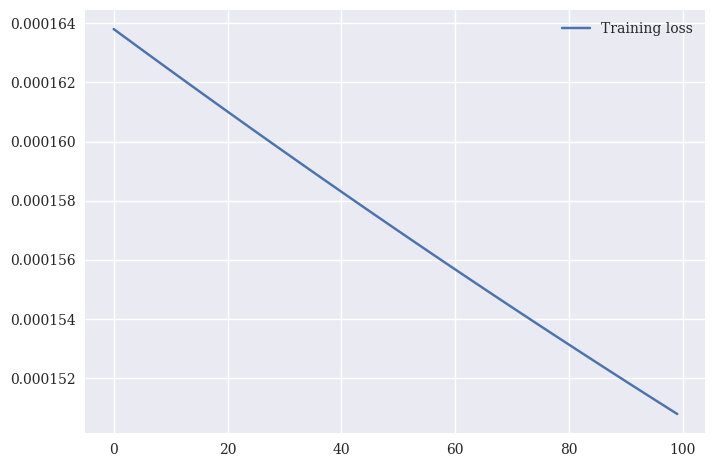

In [180]:
# Plot loss based on epochs

#####################
plt.plot(hist, label="Training loss")
plt.legend()
plt.show()
#####################

In [181]:
# make predictions

#####################
y_test_pred = model(x_test)
# invert predictions
y_train_pred = scaler.inverse_transform(y_train_pred.detach().numpy())
y_train = scaler.inverse_transform(y_train.detach().numpy())
y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
y_test = scaler.inverse_transform(y_test.detach().numpy())
#####################


# Calculate root mean squared error

#####################
trainScore = math.sqrt(mean_squared_error(y_train[:,0], y_train_pred[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[:,0], y_test_pred[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
#####################

Train Score: 5.02 RMSE
Test Score: 122.44 RMSE


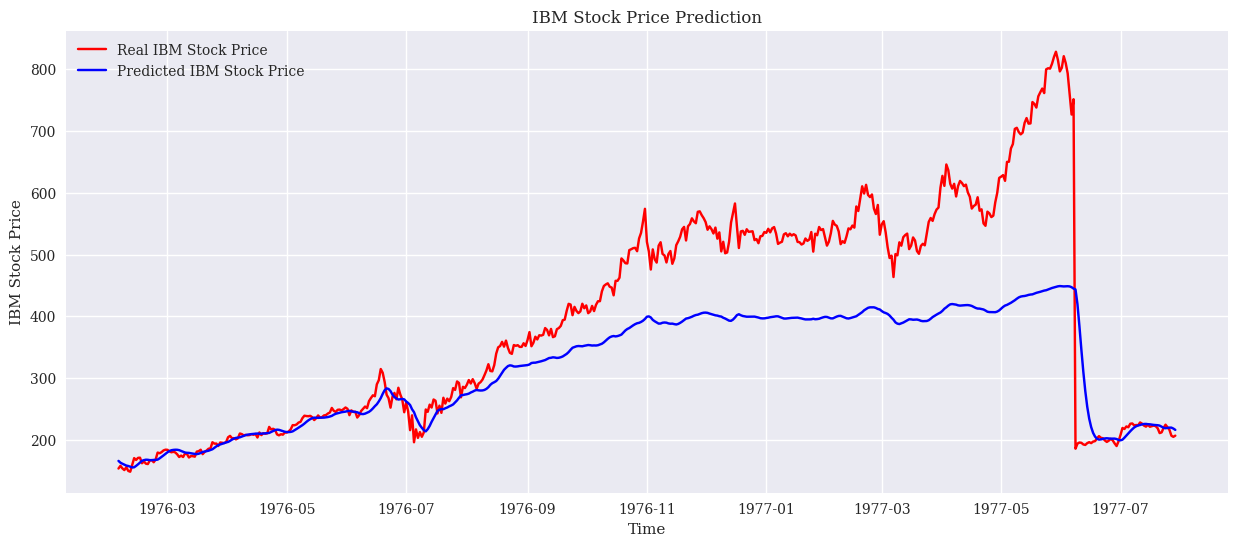

In [182]:
# Visualising the prediction results and compare LSTM and GRU models

#####################
figure, axes = plt.subplots(figsize=(15, 6))
axes.xaxis_date()

axes.plot(df_ibm[len(df_ibm)-len(y_test):].index, y_test, color = 'red', label = 'Real IBM Stock Price')
axes.plot(df_ibm[len(df_ibm)-len(y_test):].index, y_test_pred, color = 'blue', label = 'Predicted IBM Stock Price')
plt.title('IBM Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('IBM Stock Price')
plt.legend()
plt.show()
#####################